# Aide à la décision pour le mode d'imposition en tant que micro-entrepreneur au régime micro-fiscal
Choix entre les régimes :
- barème progressif de l'impôt sur le revenu avec abattement
- impôt libératoire sur le revenu sans abattement

Dans chaque cas, l'impôt est directement calculé sur le chiffre d'affaire (CA), et non sur les bénéfices.

## Paramètres

### Mon entreprise

In [1]:
# Type d'activité de la micro entreprise
# 'BNC', 'BIC_AUTRES', 'BIC_ACHAT_REVENTE'
REGIME = 'BNC'

# CA total : ceci est le CA avant abattement
CA_PERSO_BRUT = 39000

# Nombre de parts de quotient familial
N_PARTS_Q_FAMIL = 1

### Seuils et taux réglementaires au 04-09-2025

In [2]:
# Impôt libératoire
IMP_LIB = 0.022

# Abattements sur CA
DIC_ABATTEMENTS = {'BNC':0.34,
                   'BIC_AUTRES':0.5,
                   'BIC_ACHAT_REVENTE':0.71}

# Abattement plancher
ABATTEMENT_MINIMUM = 305

# Barème impôt sur le revenu 01-01-2025
LIST_DICS_TAUX_TRANCHE = [
    {'borne_inf': 11497,
     'borne_sup': 29315,
     'taux': 0.11},
    {'borne_inf': 29316,
     'borne_sup': 83823,
     'taux': 0.30},
    {'borne_inf': 83824,
     'borne_sup': 180294,
     'taux': 0.41},
    {'borne_inf': 180295,
     'taux': 0.45}
]

# Seuils au-delà desquels l'option de l'impot
# libératoire sur le revenu n'est plus possible

# Revenu fiscal de référence (RFR) de 2023, pour une application
# au 1er janvier 2025, en fonction de la part de quotient familial.
# ex : 1 part de quotient familial (personne seule) => seuil 28797€
DIC_SEUILS_OPTION_LIB = {
    1: 28797,
    2: 57594,
    2.5: 71992.5,
    3: 86391
}

### Ensemble des CA à visualiser

In [3]:
LISTE_CA = range(10, int(CA_PERSO_BRUT*1.2), 10)

## Imports

In [4]:
# Graphs et couche design
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Fonctions

In [5]:
def calcul_impots_bareme_progressif(revenu_net, list_dics_taux_tranche, n_parts):
    """ 
    Calcule le montant d'impôt en appliquant le barème progressif
    sur le revenu net après abattement, et prend en compte 
    le nombre de parts fiscales (quotient familial).
    """
    impots = 0
    
    # Revenu divisé par le nombre de parts fiscales
    revenu_part = revenu_net / n_parts

    # Calcule l'impôt en appliquant le barème des tranches ayant
    # une borne supérieure sur le revenu par part compris dans cette tranche
    for tranche in list_dics_taux_tranche[:-1]:
        
        # Si le revenu n'atteint pas la borne inférieure, aucun impôt
        if revenu_part < tranche['borne_inf']:
            break
        
        # Si borne_inf < revenu < borne_sup, applique le 
        # taux de la tranche sur la partie excédentaire
        elif revenu_part <= tranche['borne_sup']:
            impots += (revenu_part - tranche['borne_inf']) * tranche['taux']
            break
        
        else:
            # Si revenu > borne_sup, applique le taux sur toute la tranche
            impots += (tranche['borne_sup'] - tranche['borne_inf']) * tranche['taux']

    # Calcule le revenu excédant la dernière tranche
    dernier = list_dics_taux_tranche[-1]
    revenu_exces = revenu_part - dernier['borne_inf']

    if revenu_exces > 0:
        # Applique le taux de la dernière tranche sur le revenu excédentaire
        impots += revenu_exces * dernier['taux']

    # Multiplie l'impôt par le nombre de parts
    return impots * n_parts

In [6]:
def calcul_impots_liberatoire(ca, imp_lib):
    """
    Calcule le montant d'impôt sur le chiffre d'affaires (CA),
    en appliquant le taux défini par l'option libératoire de
    l'impôt sur le revenu
    """
    return ca * imp_lib

In [7]:
def calcul_ca_apres_abattement(ca, dic_abattements, abattement_min, regime):
    """
    Calcule le CA après avoir appliqué l'abattement, dépendant du
    type d'activité 'BNC', 'BIC_AUTRES', 'BIC_ACHAT_REVENTE'

    Ne s'applique que pour le régime standard d'imposition 
    avec le barème progressif (et non avec l'option libératoire)
    """
    # Récupération du taux d'abattement correspondant à
    # l'activité de l'entreprise
    taux_abattement = dic_abattements[regime]

    # Calcul du montant d'abattement
    montant_abattement = ca * taux_abattement

    # Application du seuil minimum d'abattement
    if montant_abattement < abattement_min:
        montant_abattement = abattement_min

    # Calcul du CA après abattement
    ca_apres_abattement = ca - montant_abattement

    return ca_apres_abattement

In [8]:
def calcul_intersection(liste_1, liste_2):
    """
    Calcule le point le plus proche de l'intersection
    entre deux lignes droites (définies par des listes)
    Ps: Il n'y a donc pas d'interpolation linéaire

    Méthode 1 [non implémentée] :
      Recherche de la valeur dans liste_1 qui
      soit encadrée par deux valeurs de liste_2

    Méthode 2 [implémentée] :
      Calcule de l'ensemble des écarts entre
      chaque valeur de liste_1 et de liste_2
    
      Recherche de l'écart minimum, puis 
      récupèration de l'indice, et
      récupération de la valeur correspondante
    """
    # Calcul des écarts entre liste_1 et liste_2
    liste_ecarts_x = [abs(x1 - x2) \
                       for x1, x2 in zip(liste_1, liste_2)]
    
    # Récupération de l'indice correspondant à l'écart min
    idx_min = liste_ecarts_x.index(min(liste_ecarts_x))
    
    # Déduction de la valeur d'intersection
    val_1_intersec = liste_1[idx_min]
    val_2_intersec = liste_2[idx_min]
    
    return idx_min, (val_1_intersec, val_2_intersec)

## Calculs

In [9]:
# Montants impots en libératoire
liste_impots_lib = [calcul_impots_liberatoire(ca, IMP_LIB) for ca in LISTE_CA]

# CAs après abattement
liste_ca_apres_abattement = [calcul_ca_apres_abattement(ca, DIC_ABATTEMENTS, ABATTEMENT_MINIMUM, REGIME) \
    for ca in LISTE_CA]

# Montants impots en progressif basés
# sur CAs après abattement
liste_impots_progress = [
    calcul_impots_bareme_progressif(ca_aps_abattement, LIST_DICS_TAUX_TRANCHE, N_PARTS_Q_FAMIL)
    for ca_aps_abattement in liste_ca_apres_abattement
]

# Limite de droit à l'option en fonction
# du quotient familial
limite_ca_option = DIC_SEUILS_OPTION_LIB[N_PARTS_Q_FAMIL]

# Récupération de l'indice et des deux valeurs d'impôts
# auxquelles les deux régimes se valent~ (intersection)
point_intersec, imps_intersec = \
    calcul_intersection(liste_impots_lib, liste_impots_progress)

# Déduction du CA d'intersection
ca_intersec = LISTE_CA[point_intersec]

# 'Interpolation' de l'impôt d'intersection
imp_intersec = (imps_intersec[0]+imps_intersec[1])/2

# Coordonnées de l'intersection combinées sous
# format texte
intersec_coords = "CA: {:.0f}€\nImpôts: {:.0f}€".format(ca_intersec, imp_intersec)

## Graph

Nb : La taille du graph et le positionnement des coordonnées de l'intersection ont été définies arbitrairement et ne sont donc pas dynamiques

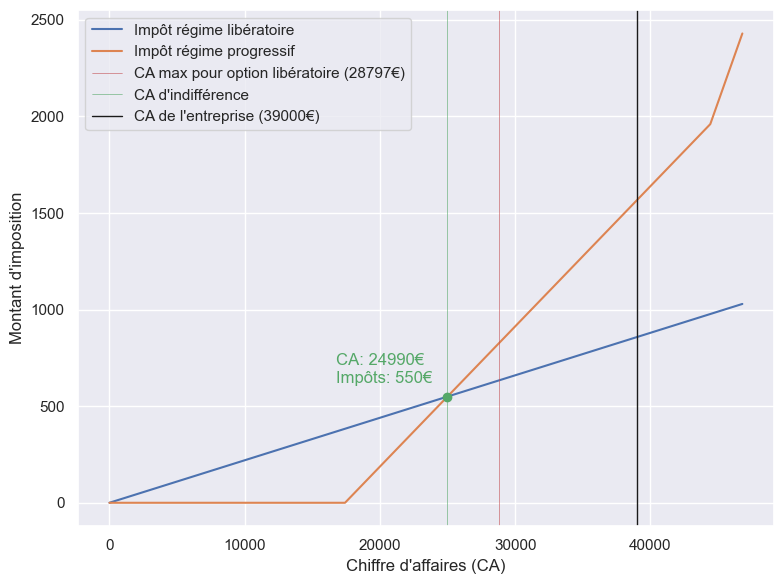

In [10]:
# Définition de la taille du graph
plt.figure(figsize=(8,6))

# Tracé des lignes pour les deux régimes
plt.plot(LISTE_CA, liste_impots_lib, label="Impôt régime libératoire")
plt.plot(LISTE_CA, liste_impots_progress, label="Impôt régime progressif")

# Ajout du point d’intersection
plt.plot(ca_intersec, imp_intersec, marker='o', color='g')

# Annotation du point d'intersection avec coordonnées dynamiques
plt.annotate(
    f"CA: {ca_intersec:.0f}€\nImpôts: {imp_intersec:.0f}€",
    xy=(ca_intersec, imp_intersec),
    xytext=(-80, 10),
    textcoords="offset points",
    color='g'
)

# Ajout des lignes verticales repères avec labels dynamiques
plt.axvline(x=limite_ca_option, label=f"CA max pour option libératoire ({limite_ca_option:.0f}€)",
            linewidth=0.4, color='r')
plt.axvline(x=ca_intersec, label="CA d'indifférence", linewidth=0.4, color='g')
plt.axvline(x=CA_PERSO_BRUT, label=f"CA de l'entreprise ({CA_PERSO_BRUT:.0f}€)", linewidth=1, color='k')

# Labels axes
plt.xlabel("Chiffre d'affaires (CA)")
plt.ylabel("Montant d'imposition")

# Légende et affichage
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
print("## Conclusion :")
print(f"- Il faut avoir un CA > {ca_intersec:.0f}€ pour que l'option libératoire devienne plus avantageuse que le barème progressif.")
print(f"- Cette option n'est possible que si le revenu fiscal de référence (RFR) N-2 est inférieur à {limite_ca_option:.0f}€ (pour {N_PARTS_Q_FAMIL} part(s) de quotient familial).")
if ca_intersec < limite_ca_option:
    print(f"- Donc, le régime libératoire est intéressant uniquement si le CA est compris entre {ca_intersec:.0f}€ et {limite_ca_option:.0f}€.")
else:
    print("- Mais comme le seuil d’option est inférieur au point d’indifférence, l’option libératoire n’est **jamais** avantageuse dans ce cas.")

## Conclusion :
- Il faut avoir un CA > 24990€ pour que l'option libératoire devienne plus avantageuse que le barème progressif.
- Cette option n'est possible que si le revenu fiscal de référence (RFR) N-2 est inférieur à 28797€ (pour 1 part(s) de quotient familial).
- Donc, le régime libératoire est intéressant uniquement si le CA est compris entre 24990€ et 28797€.
